<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap16_2_idmb_classification_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capítulo 16 - Mecanismos de Atenção

Para esse notebook Python, utilizaremos a camada Layer do Keras, cuja documentação pode ser acessada [aqui](https://keras.io/api/layers/attention_layers/attention/).

## 16.2 Classificação de reviews de filmes utilizando Redes Neurais Recorrentes e Atenção

Informações sobre o corpus IMDB Reviews, clique [aqui](https://www.tensorflow.org/datasets/catalog/imdb_reviews).

In [ ]:
!pip install tensorflow-datasets
!pip install keras
!pip install tensorflow
!pip install -U gensim

In [2]:
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,Activation,SimpleRNN,BatchNormalization,RNN,Flatten,Input,LSTM,Bidirectional,Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gensim
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from tensorflow.keras.optimizers import Adam

In [3]:
ds_train = tfds.load('imdb_reviews/plain_text', split='train', shuffle_files=True)
ds_test = tfds.load('imdb_reviews/plain_text', split='test', shuffle_files=False)

In [4]:
df_train = tfds.as_dataframe(ds_train)
df_test = tfds.as_dataframe(ds_test)

In [5]:
df_train.head()

,label,text
0,0,"b""This was an absolutely terrible movie. Don't..."
1,0,b'I have been known to fall asleep during film...
2,0,b'Mann photographs the Alberta Rocky Mountains...
3,1,b'This is the kind of film for a snowy Sunday ...
4,1,"b'As others have mentioned, all the women that..."


In [6]:
def preprocessDataFrame(df):

    dic = {}
    dic['text'] = []
    dic['label'] = []

    review = [x.decode('utf-8') for x in df['text'].values]
    #class_label = [x.decode('utf-8') for x in df['label'].values]

    for idx,sentence in enumerate(review):
        dic['text'].append(review[idx])
        dic['label'].append(df['label'][idx])
        
    return pd.DataFrame.from_dict(dic)

In [7]:
df_train = preprocessDataFrame(df_train)
df_test = preprocessDataFrame(df_test)

In [8]:
df_train.head()

,text,label
0,This was an absolutely terrible movie. Don't b...,0
1,"I have been known to fall asleep during films,...",0
2,Mann photographs the Alberta Rocky Mountains i...,0
3,This is the kind of film for a snowy Sunday af...,1
4,"As others have mentioned, all the women that g...",1


In [9]:
df_train['label'] = pd.Categorical(df_train['label'])
y_train_int = df_train['label'].cat.codes

df_test['label'] = pd.Categorical(df_test['label'])
y_test_int = df_test['label'].cat.codes

y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)

In [10]:
train_reviews = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_reviews)):
    train_reviews[i] = train_reviews[i].lower()
    for word in train_reviews[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

In [11]:
trunc_type = 'post'
padding_type = 'post'
max_length = 32
vocab_size = len(vocabulary)

In [12]:
train_reviews = df_train['text'].to_list()

vocabulary = {}

for i in range(0,len(train_reviews)):
    train_reviews[i] = train_reviews[i].lower()
    for word in train_reviews[i].split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word]+=1

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(df_train['text'])

word_index = tokenizer.word_index
print(f"{word_index['blue']} is the index of word 'blue'")
print(f"{word_index['launch']} is the index of word 'launch'")

train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

1331 is the index of word 'blue'
7292 is the index of word 'launch'


In [22]:
model = Sequential()

model.add(Input(shape=(None,),dtype="int64"))
model.add(Embedding(input_dim = vocab_size, output_dim = 32))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(2, activation='softmax'))

adam = Adam(learning_rate=0.00002)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_padded, y_train, epochs=6, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/6
625/625 [==============================] - 84s 126ms/step - loss: 0.6929 - accuracy: 0.5181 - val_loss: 0.6925 - val_accuracy: 0.5454
Epoch 2/6
625/625 [==============================] - 78s 125ms/step - loss: 0.6844 - accuracy: 0.5963 - val_loss: 0.6415 - val_accuracy: 0.6304
Epoch 3/6
625/625 [==============================] - 78s 124ms/step - loss: 0.5831 - accuracy: 0.6898 - val_loss: 0.5800 - val_accuracy: 0.6932
Epoch 4/6
625/625 [==============================] - 77s 123ms/step - loss: 0.5134 - accuracy: 0.7477 - val_loss: 0.5564 - val_accuracy: 0.7160
Epoch 5/6
625/625 [==============================] - 77s 123ms/step - loss: 0.4651 - accuracy: 0.7814 - val_loss: 0.5508 - val_accuracy: 0.7196
Epoch 6/6
625/625 [==============================] - 77s 123ms/step - loss: 0.4259 - accuracy: 0.8071 - val_loss: 0.5531 - val_accuracy: 0.7288


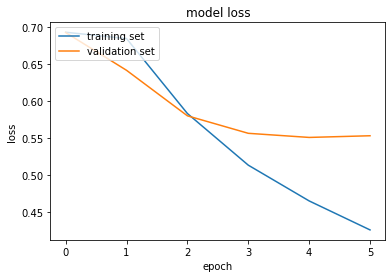

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [24]:
y_prob = model.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

782/782 [==============================] - 11s 13ms/step
              precision    recall  f1-score   support

           0       0.72      0.67      0.70     12500
           1       0.69      0.74      0.72     12500

    accuracy                           0.71     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.71      0.71      0.71     25000



Com Atenção

In [25]:
input_layer = Input(shape=(None,),dtype="int64")

embedding_layer = Embedding(input_dim = vocab_size, output_dim = 32)(input_layer)

bilstm = Bidirectional(LSTM(100))

query = bilstm(embedding_layer)
values = bilstm(embedding_layer)

query_value_attention_seq = Attention(use_scale=True, score_mode="dot")([query, values])

output_layer = Dense(2, activation='softmax')(query_value_attention_seq)

model_att = Model(inputs=input_layer,outputs=output_layer)

adam = Adam(learning_rate=0.00002)

model_att.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

history = model_att.fit(train_padded, y_train, epochs=6, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/6
625/625 [==============================] - 106s 160ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 2/6
625/625 [==============================] - 99s 158ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 3/6
625/625 [==============================] - 100s 160ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 4/6
625/625 [==============================] - 99s 158ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 5/6
625/625 [==============================] - 100s 159ms/step - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 6/6
625/625 [==============================] - 99s 158ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4938


In [26]:
y_prob = model_att.predict(test_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred))

782/782 [==============================] - 19s 22ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12500
           1       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
